<a href="https://colab.research.google.com/github/VictorRojano28/Predicci-n-de-Generaci-n-de-Energ-a-en-el-Estado-de-Puebla/blob/main/LSTM_GeneracionDeEnerg%C3%ADaPuebla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2563 - mae: 0.4783 - val_loss: 0.0564 - val_mae: 0.2121
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0559 - mae: 0.1964 - val_loss: 0.0164 - val_mae: 0.1005
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0307 - mae: 0.1352 - val_loss: 0.0132 - val_mae: 0.0981
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0387 - mae: 0.1501 - val_loss: 0.0127 - val_mae: 0.0950
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0330 - mae: 0.1361 - val_loss: 0.0121 - val_mae: 0.0892
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0375 - mae: 0.1456 - val_loss: 0.0128 - val_mae: 0.0961
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0300 - mae: 0.1337 - val_loss: 0.0121 - val_mae: 0.0899
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0427 - mae: 0.1587 - val_loss: 0.0121 - val_mae: 0.0912
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0284 - mae: 0.

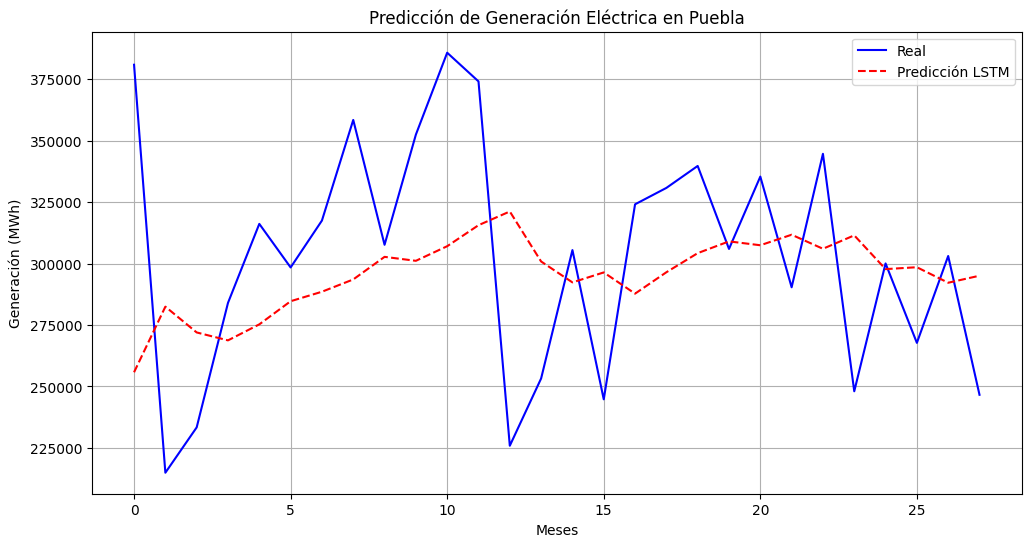


Métricas:
- MAE: 41053.36 MWh
- RMSE: 49747.72 MWh


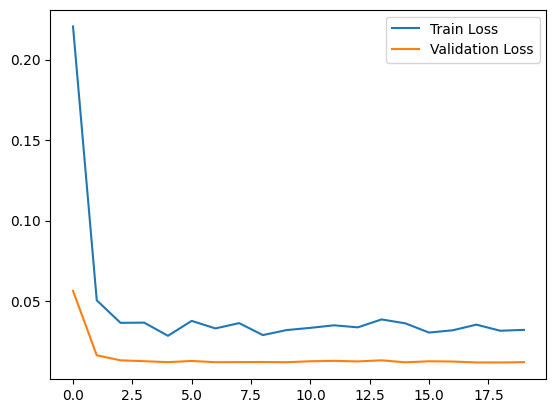

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Extraer solo datos de Puebla desde archivo Excel
ruta = '/content/drive/MyDrive/prueba.xlsx'
df = pd.read_excel(ruta, sheet_name=0, header=None)

# Buscar la fila donde aparece puebla
fila_puebla = df[df.iloc[:, 0].astype(str).str.contains('Puebla', case=False, na=False)].index[0]
valores_puebla = df.iloc[fila_puebla, 1:].values
valores_puebla = pd.to_numeric(valores_puebla, errors='coerce')

# Crear fechas desde enero 2010 con la misma longitud que los valores
fechas = pd.date_range(start='2010-01', periods=len(valores_puebla), freq='MS')
fechas = fechas[:len(valores_puebla)]

# Crear DataFrame con las fechas y generación
data = pd.DataFrame({
    'Fecha': fechas,
    'Generacion_MWh': valores_puebla
}).dropna().set_index('Fecha')

# Normalizar datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Creación de secuencias temporales
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 18  # Número de meses a utilizar
X, y = create_sequences(data_scaled, window_size)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
split = int(0.8 * len(X)) #80 entrenamiento 20 prueba
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Construcción del modelo LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early Stopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

y_pred = model.predict(X_test) # Predicción y evaluación
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)) # Para invertir la normalización
y_pred_real = scaler.inverse_transform(y_pred)

# Métricas
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Real', color='blue')
plt.plot(y_pred_real, label='Predicción LSTM', color='red', linestyle='--')
plt.title('Predicción de Generación Eléctrica en Puebla')
plt.xlabel('Meses')
plt.ylabel('Generación (MWh)')
plt.legend()
plt.grid(True)
plt.show()

print(f'\nMétricas:')
print(f'- MAE: {mae:.2f} MWh')
print(f'- RMSE: {rmse:.2f} MWh')

# Gráfico de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [18]:
ultimo_input = data_scaled[-window_size:]
ultimo_input = np.reshape(ultimo_input, (1, window_size, 1))

# Predecir el mes siguiente
pred_proximo_mes = model.predict(ultimo_input)
pred_proximo_mes_real = scaler.inverse_transform(pred_proximo_mes)
ultimo_mes = data.index[-1]
proximo_mes = ultimo_mes + pd.DateOffset(months=1)

print(f'\nPredicción para {proximo_mes.strftime("%B %Y")}: {pred_proximo_mes_real[0,0]:.2f} MWh')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Predicción para March 2023: 289014.19 MWh


Se utiliza una red neuronal recurrente (RNN), específicamente una LSTM, debido a su capacidad para modelar dependencias temporales en series de tiempo, como lo es la generación de energía eléctrica mensual. A diferencia de las redes neuronales tradicionales, las LSTM pueden retener información relevante a lo largo del tiempo, lo que las hace especialmente útiles en contextos donde el comportamiento pasado influye en el futuro. En cuanto al optimizador, se emplea Adam, ya que combina las ventajas de los métodos AdaGrad y RMSProp, ajustando dinámicamente la tasa de aprendizaje para cada parámetro. Esto permite una convergencia más rápida y eficiente, especialmente en problemas complejos como la predicción de series temporales no lineales.